In [2]:
import os,sys
print(os.getcwd())
os.chdir('fair-classification/disparate_impact/synthetic_data_demo')
import numpy as np
from generate_synthetic_data import *
sys.path.insert(0, '../../fair_classification/') # the code for fair classification is in this directory
import utils as ut
import loss_funcs as lf # loss funcs that can be optimized subject to various constraints

import pandas as pd

%matplotlib inline  

%load_ext autoreload

%autoreload 2

import pdb

C:\Users\hamsh\Documents\DMA\compas-recidivism-racial-bias


In [3]:
compas_data = pd.read_csv('../../../compas-data/compas-scores-two-years.csv')


In [4]:
features = ['sex', 'priors_count', 'age', 'c_charge_degree', 'juv_fel_count', 
            'juv_misd_count']

target = ['two_year_recid']
sensitive = ['race']

compas_light = compas_data.filter(features + target + sensitive)

compas_light = compas_light[compas_light.race.isin(['African-American', 'Caucasian'])]
compas_light['race'] = compas_light['race'].map({'African-American': 1.0, 'Caucasian': 0.0})
compas_light['sex'] = compas_light['sex'].map({'Male': 1.0, 'Female': 0.0})
compas_light['two_year_recid'] = compas_light['two_year_recid'].map({1: 1.0, 0: -1.0})
compas_light['c_charge_degree'] = compas_light['c_charge_degree'].map({'F': 1, 'M': 0})


In [5]:
compas_light.head()

,sex,priors_count,age,c_charge_degree,juv_fel_count,juv_misd_count,two_year_recid,race
1,1.0,0,34,1,0,0,1.0,1.0
2,1.0,4,24,1,0,0,1.0,1.0
3,1.0,1,23,1,0,1,-1.0,1.0
6,1.0,14,41,1,0,0,1.0,0.0
8,0.0,0,39,0,0,0,-1.0,0.0


In [6]:
from sklearn.preprocessing import StandardScaler

#X = StandardScaler().fit_transform(compas_light[['is_male', 'age', 'priors_count']])
X = np.array(compas_light[features])

y = np.array(compas_light.two_year_recid)
x_control = {"race": np.array(compas_light.race)}
X.shape

(6150L, 6L)

C:\Users\hamsh\Anaconda3\envs\ipykernel_py2\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


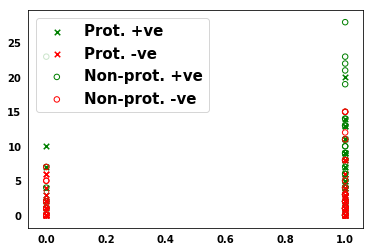

In [7]:
num_to_draw = 200 # we will only draw a small number of points to avoid clutter
x_draw = X[:num_to_draw]
y_draw = y[:num_to_draw]
x_control_draw = x_control['race'][:num_to_draw]

X_s_0 = x_draw[x_control_draw == 0.0] #white
X_s_1 = x_draw[x_control_draw == 1.0] #black
y_s_0 = y_draw[x_control_draw == 0.0] # target values for whites
y_s_1 = y_draw[x_control_draw == 1.0] # target values for blacks
plt.scatter(X_s_0[y_s_0==1.0][:, 0], X_s_0[y_s_0==1.0][:, 1], color='green', marker='x', s=30, linewidth=1.5, label= "Prot. +ve")
plt.scatter(X_s_0[y_s_0==-1.0][:, 0], X_s_0[y_s_0==-1.0][:, 1], color='red', marker='x', s=30, linewidth=1.5, label = "Prot. -ve")
plt.scatter(X_s_1[y_s_1==1.0][:, 0], X_s_1[y_s_1==1.0][:, 1], color='green', marker='o', facecolors='none', s=30, label = "Non-prot. +ve")
plt.scatter(X_s_1[y_s_1==-1.0][:, 0], X_s_1[y_s_1==-1.0][:, 1], color='red', marker='o', facecolors='none', s=30, label = "Non-prot. -ve")

#green cross : whites that were predicted to be recids
# red cross: whites that were not predicted to be recids


# green circle: blacks that were predicted to be recids
# red circle: blacks that were not predicted to be recids 

# x axis: females
# y axis: males

plt.tick_params(axis='x', which='both', bottom='off', top='off') # dont need the ticks to see the data distribution
plt.tick_params(axis='y', which='both', left='off', right='off')
plt.legend(loc=2, fontsize=15)
plt.savefig("img/data.png")
plt.show()


In [8]:
X_s_0[y_s_0==1.0][:,0]

array([1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0.,
       1., 1., 1., 0., 1., 0., 1., 1.])

In [9]:
print(compas_data[(compas_data.race == 'African-American') & (compas_data.two_year_recid == True)].shape)
print(compas_data[(compas_data.race == 'Caucasian') & (compas_data.two_year_recid == False)].shape)
print(compas_data[(compas_data.race == 'Caucasian')].shape)
print(compas_data[(compas_data.race == 'African-American')].shape)

ut.compute_p_rule(x_control['race'], y)  # compute the p-rule i

#Non-protected in positive class: 1901 (51%): blacks convicted
#Protected in positive class: 966 (39%): whites convicted

(1901, 53)
(1488, 53)
(2454, 53)
(3696, 53)

Total data points: 6150
# non-protected examples: 3696
# protected examples: 2454
Non-protected in positive class: 1901 (51%)
Protected in positive class: 966 (39%)
P-rule is: 77%


76.53364784201855

In [10]:
X = ut.add_intercept(X) # add intercept to X before applying the linear classifier
 #the train test split needs keys in case there are several protected attributes

In [11]:
train_fold_size = 0.7
x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)
x_test

array([[1., 1., 2., ..., 1., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 2., ..., 1., 0., 0.],
       ...,
       [1., 1., 0., ..., 1., 0., 0.],
       [1., 1., 0., ..., 1., 0., 0.],
       [1., 0., 3., ..., 0., 0., 0.]])

In [12]:
loss_function = lf._logistic_loss
sensitive_attrs = ["race"]
gamma = None

sensitive_attrs_name = sensitive_attrs[0]

In [13]:
def train_test_classifier():
    w = ut.train_model(x_train, y_train, x_control_train, loss_function, apply_fairness_constraints, apply_accuracy_constraint, sep_constraint, sensitive_attrs, sensitive_attrs_to_cov_thresh, gamma)
    train_score, test_score, correct_answers_train, correct_answers_test, y_train_predicted, y_test_predicted = ut.check_accuracy(w, x_train, y_train, x_test, y_test, None, None)
    distances_boundary_test = (np.dot(x_test, w)).tolist()
    all_class_labels_assigned_test = np.sign(distances_boundary_test)
    correlation_dict_test = ut.get_correlations(None, None, all_class_labels_assigned_test, x_control_test, sensitive_attrs)
    cov_dict_test = ut.print_covariance_sensitive_attrs(None, x_test, distances_boundary_test, x_control_test, sensitive_attrs)
    p_rule = ut.print_classifier_fairness_stats([test_score], [correlation_dict_test], [cov_dict_test], sensitive_attrs[0])	
    return w, p_rule, test_score, y_test_predicted

In [14]:
def accuracy_per_group(x, y, x_control, w):
    
    def predict(x):
        return(np.sign(np.dot(x, w)))
    
    def results_protected_group(group = 1):
        
        def results_prediction_category(prediction = 1):
            mask = np.array([i == prediction for i in predict(x_group)])
            correct = sum(predict(x_group[mask]) == y_group[mask])
            false = sum(mask) - correct
            return correct, false
        
        mask = np.array([i == group for i in x_control['race']])
        x_group = x[mask]
        y_group = y[mask]
        FP, TP = results_prediction_category(prediction = 1)
        FN, TN = results_prediction_category(prediction = -1)     
        return FP, TP, FN, TN
    
    FP1, TP1, FN1, TN1 = results_protected_group(1)
    FP0, TP0, FN0, TN0 = results_protected_group(0)
    
    return FP1, TP1, FN1, TN1, FP0, TP0, FN0, TN0
    

In [15]:
def false_positives_per_group(x, y, x_control, w):
    FP1, TP1, FN1, TN1, FP0, TP0, FN0, TN0 = accuracy_per_group(x, y, x_control, w) 
    
    N = 2
    errors = (FP1, FN0)
    correct = (TP1, TN0)
    ind = np.arange(N)    # the x locations for the groups
    width = 0.35       # the width of the bars: can also be len(x) sequence

    p1 = plt.bar(ind, errors, width, color='#d62728')
    p2 = plt.bar(ind, correct, width, bottom = errors)

    plt.ylabel('Population')
    plt.title('Prediction accuracy by group and prediction')
    plt.xticks(ind, ('White', 'Black'))
    plt.yticks(np.arange(0, max(errors) + max(correct), 100))
    plt.legend((p1[0], p2[0]), ('False', 'True'))

    return(plt.show())
    

In [16]:
def pie_false_positives_per_group(x, y, x_control, w, group):
    FP1, TP1, FN1, TN1, FP0, TP0, FN0, TN0 = accuracy_per_group(x, y, x_control, w) 
    if group is 'whites':
        plt.pie([FP1, TP1], labels=['Incorrect prediction', 'Correct Prediction'], autopct='%1.1f%%', shadow=True)
    else: 
        plt.pie([FP0, TP0], labels=['Incorrect prediction', 'Correct Prediction'], autopct='%1.1f%%', shadow=True)
        
    plt.title('Accuracy for recidivist predictions for '+ group)

    return(plt.show())
    


In [17]:
def pie_false_negatives_per_group(x, y, x_control, w, group):
    FP1, TP1, FN1, TN1, FP0, TP0, FN0, TN0 = accuracy_per_group(x, y, x_control, w) 
    if group is 'whites':
        plt.pie([FN1, TN1], labels=['Incorrect prediction', 'Correct Prediction'], autopct='%1.1f%%', shadow=True)
    else: 
        plt.pie([FN0, TN0], labels=['Incorrect prediction', 'Correct Prediction'], autopct='%1.1f%%', shadow=True)
        
    plt.title('Accuracy for non-recidivist predictions for '+ group)

    return(plt.show())
    


In [18]:
def bar_chart_accuracy_per_group(x, y, x_control, w):
    FP1, TP1, FN1, TN1, FP0, TP0, FN0, TN0 = accuracy_per_group(x, y, x_control, w) 
    
    N = 4
    errors = (FN1, FP1, FN0, FP0)
    correct = (TN1, TP1, TN0, TP0)
    ind = np.arange(N)    # the x locations for the groups
    width = 0.35       # the width of the bars: can also be len(x) sequence

    p1 = plt.bar(ind, errors, width, color='#d62728')
    p2 = plt.bar(ind, correct, width, bottom = errors)

    plt.ylabel('Population')
    plt.title('Prediction accuracy by group and prediction')
    plt.xticks(ind, ('Black Low', 'Black High', 'White Low', 'White High'))
    plt.yticks(np.arange(0, max(errors) + max(correct), 100))
    plt.legend((p1[0], p2[0]), ('False', 'True'))

    return(plt.show())
    
    

Accuracy: 0.67
Protected/non-protected in +ve class: 26% / 52%
P-rule achieved: 50%
Covariance between sensitive feature and decision from distance boundary : 0.129

(array([-1., -1., -1., ..., -1., -1., -1.]), 'acc')


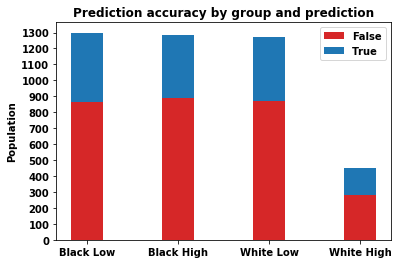

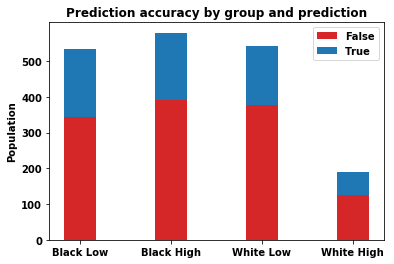

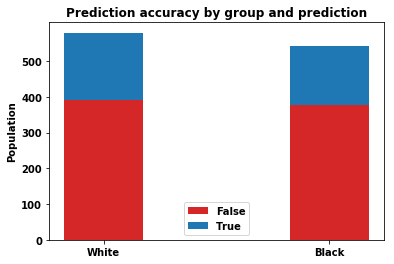

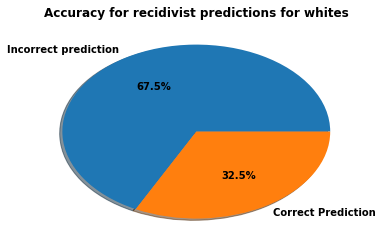

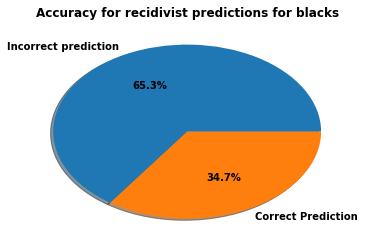

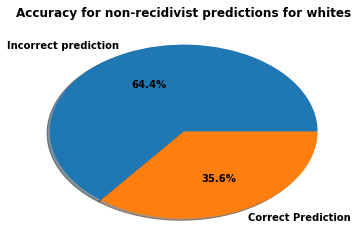

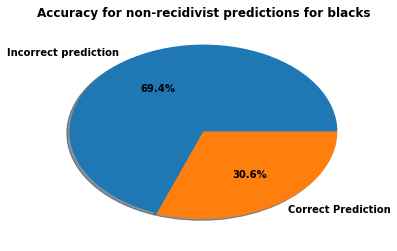

In [19]:
sensitive_attrs_to_cov_thresh = {}
apply_fairness_constraints = 0 #P
apply_accuracy_constraint = 0 # accuracy above a certain threshhold 
sep_constraint = 0 # if you want both


w, p, acc, y_pred = train_test_classifier()
print(y_pred, 'acc')
bar_chart_accuracy_per_group(x_train, y_train, x_control_train, w)
bar_chart_accuracy_per_group(x_test, y_test, x_control_test, w)
false_positives_per_group(x_test, y_test, x_control_test, w)
pie_false_positives_per_group(x_test, y_test, x_control_test, w, 'whites')
pie_false_positives_per_group(x_test, y_test, x_control_test, w, 'blacks')

pie_false_negatives_per_group(x_test, y_test, x_control_test, w, 'whites')
pie_false_negatives_per_group(x_test, y_test, x_control_test, w, 'blacks')

Accuracy: 0.53
Protected/non-protected in +ve class: 16% / 18%
P-rule achieved: 89%
Covariance between sensitive feature and decision from distance boundary : 0.001



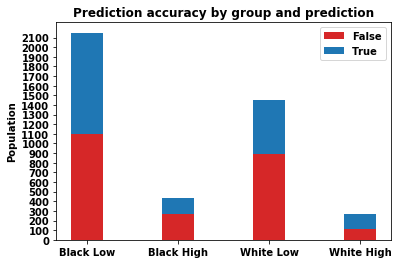

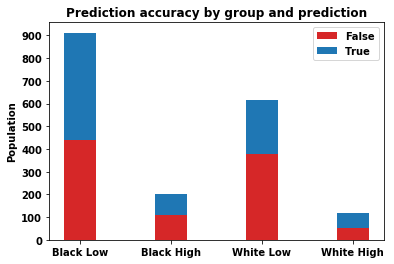

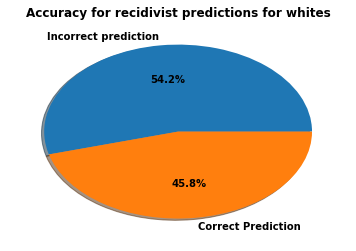

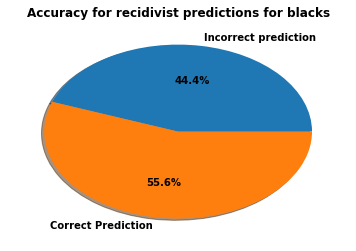

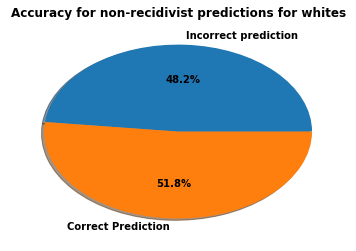

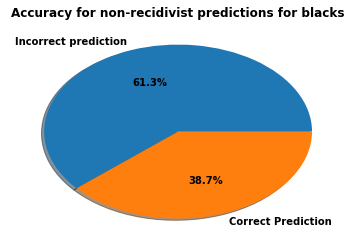

In [20]:
apply_fairness_constraints = 1
apply_accuracy_constraint = 0
sep_constraint = 0
threshold = 0
sensitive_attrs_to_cov_thresh = {sensitive_attrs_name: threshold}

w, p, acc, y_pred_fairness = train_test_classifier()

bar_chart_accuracy_per_group(x_train, y_train, x_control_train, w)
bar_chart_accuracy_per_group(x_test, y_test, x_control_test, w)

pie_false_positives_per_group(x_test, y_test, x_control_test, w, 'whites')
pie_false_positives_per_group(x_test, y_test, x_control_test, w, 'blacks')

pie_false_negatives_per_group(x_test, y_test, x_control_test, w, 'whites')
pie_false_negatives_per_group(x_test, y_test, x_control_test, w, 'blacks')

In [21]:
print(y_pred.shape)
y_test.shape
x_test.shape
print(y_pred_fairness)
x_test_df = pd.DataFrame(x_test, columns=list(features))
x_test_df['Y_acc'] = pd.Series(y_pred, index=x_test_df.index)


(1845L,)
[-1. -1. -1. ... -1. -1. -1.]


ValueError: Shape of passed values is (7, 1845), indices imply (6, 1845)

In [22]:
x_test_df['Y_fairness'] = pd.Series(y_pred_fairness, index=x_test_df.index)
x_test_df['Y_actual'] = pd.Series(y_test, index=x_test_df.index)
x_test_df['Similar_preds'] = np.where(x_test_df['Y_acc']==x_test_df['Y_fairness'], 
                                           1, 0)
x_test_df.head()
x_test_df.corr(method='pearson', min_periods=1)

#find factors that do change with changes in similarity index 
plt.matshow(x_test_df.corr())
# age and similar preds?

NameError: name 'x_test_df' is not defined

In [23]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = x_test_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

ImportError: No module named seaborn

In [24]:
apply_fairness_constraints = 0
apply_accuracy_constraint = 1
sep_constraint = 0
gamma = 0.08

w, p, acc = train_test_classifier()

bar_chart_accuracy_per_group(x_train, y_train, x_control_train, w)
bar_chart_accuracy_per_group(x_test, y_test, x_control_test, w)

pie_false_positives_per_group(x_test, y_test, x_control_test, w, 'whites')
pie_false_positives_per_group(x_test, y_test, x_control_test, w, 'blacks')

pie_false_negatives_per_group(x_test, y_test, x_control_test, w, 'whites')
pie_false_negatives_per_group(x_test, y_test, x_control_test, w, 'blacks')

Accuracy: 0.60
Protected/non-protected in +ve class: 10% / 24%
P-rule achieved: 41%
Covariance between sensitive feature and decision from distance boundary : 0.019



ValueError: too many values to unpack

In [ ]:
apply_fairness_constraints = 0
apply_accuracy_constraint = 1
sep_constraint = 1
gamma = 0.1
threshold = 0
sensitive_attrs_to_cov_thresh = {sensitive_attrs_name: threshold}

w, p, acc = train_test_classifier()

bar_chart_accuracy_per_group(x_train, y_train, x_control_train, w)
bar_chart_accuracy_per_group(x_test, y_test, x_control_test, w)

pie_false_positives_per_group(x_test, y_test, x_control_test, w, 'whites')
pie_false_positives_per_group(x_test, y_test, x_control_test, w, 'blacks')

pie_false_negatives_per_group(x_test, y_test, x_control_test, w, 'whites')
pie_false_negatives_per_group(x_test, y_test, x_control_test, w, 'blacks')